In [140]:
import random
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import torch.nn as nn
import torch.optim as optim
import matplotlib.animation as animation
from IPython.display import HTML  # For displaying in Jupyter


In [141]:

# --- Helper dictionaries  ---
color_strings = {
    0: "red",
    1: "green",
    2: "blue"
}
color_hexs = {
    0: [0xFF, 0x00, 0x00],
    1: [0x00, 0xFF, 0x00],
    2: [0x00, 0x00, 0xFF]
}
color_one_hots = {
    0: [1, 0, 0],
    1: [0, 1, 0],
    2: [0, 0, 1]
}
# --- Scoring Constants:
RED_WIN = 1
GREEN_WIN = 1
BLUE_WIN = 1
RED_LOSE = 1
GREEN_LOSE = 1
BLUE_LOSE = 1

In [142]:
# --- Brain Class Definition ---
class Brain(nn.Module):
    def __init__(self, input_units = 15, num_hidden_layers = 1, hidden_units = 8, output_units = 3, activation='ReLU'):
        super(Brain, self).__init__()
        self.num_input_units = input_units
        self.num_hidden_layers = num_hidden_layers
        self.num_hidden_units = hidden_units
        self.output_units = output_units
        self.input_layer = nn.Linear(self.num_input_units, self.num_hidden_units)
        self.hidden_layers = []
        for layer_num in range(num_hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(self.num_hidden_units, self.num_hidden_units))
        self.output_layer = nn.Linear(self.num_hidden_units, self.output_units)
        self.activation_str = activation
        match activation:
            case "ReLU":
                self.activation = nn.ReLU()
            case "ELU":
                self.activation = nn.ELU()
            case "Hardswish":
                self.activation = nn.Hardswish()
            case "SELU":
                self.activation = nn.SELU()
            case "PReLU":
                self.activation = nn.PReLU()
            case "LeakyReLU":
                self.activation = nn.LeakyReLU()
            case "ReLU6":
                 self.activation = nn.ReLU6()
            case "SiLU":
                self.activation = nn.SiLU()
            case "Mish":
                self.activation = nn.Mish()
            case "Softplus":
                self.activation = nn.Softplus()
            case "CELU":
                self.activation = nn.CELU()
            case _:
                raise ValueError("Invalid activation")

    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation(x)
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = self.activation(x)
        y = self.output_layer(x)
        return y


In [143]:
# --- Cell Class Definition ---
class Cell():
    def __init__(self, hidden_layers = 1, hidden_size = 8, learn_rate = 0.01, activation = 'ReLU', row=0, col=0):
        self.row_num = row
        self.col_num = col
        self.hp = 50
        self.good_outcomes = 0
        self.bad_outcomes = 0
        self.entropy = None
        self. accuracy = None
        self.color = random.randint(0, 2)
        self.hidden_layers = hidden_layers
        self.hidden_size = hidden_size
        self.learn_rate = learn_rate
        self.next_throw = self.color
        self.neighbors = []
        self.activation = activation
        self.brain = Brain(
            hidden_units = self.hidden_size,
            num_hidden_layers = self.hidden_layers,
            activation = self.activation
        )
        self.optimizer = optim.SGD(self.brain.parameters(), lr=learn_rate)
        self.loss = nn.CrossEntropyLoss()
        self.choice_dist = torch.tensor([0.333, 0.333, 0.333], dtype=torch.float, requires_grad=True)

    def make_choice(self, sense_data):
        # use the neural net to choose what color to throw next turn
        vect_sense = torch.reshape(sense_data, (-1,))
        self.choice_dist = self.brain(vect_sense)
        self.next_throw = torch.argmax(self.choice_dist)
        return self.choice_dist

    def learn(self, optimal_throw_tensor):
        # calculate gradients for parameters based on loss
        self.loss_object = self.loss(self.choice_dist, optimal_throw_tensor)
        self.loss_object.backward()

    def update(self):
        # alter weights and biases of neural net
        self.optimizer.step()
        self.optimizer.zero_grad()

    def evaluate(self, my_color_one_hot = None, sense_data = None):
        num_red_neighbors = 0
        num_green_neighbors = 0
        num_blue_neighbors = 0
        for neighbor in self.neighbors:
            if neighbor.color == 0:
                num_red_neighbors += 1
            if neighbor.color == 1:
                num_green_neighbors += 1
            if neighbor.color == 2:
                num_blue_neighbors += 1
        if my_color_one_hot is None:
            self_is_red, self_is_green, self_is_blue = self.color_one_hot()
        else:
            self_is_red, self_is_green, self_is_blue = my_color_one_hot
        wins =  RED_WIN * (self_is_red * num_green_neighbors) +  GREEN_WIN * (self_is_green * num_blue_neighbors) + BLUE_WIN * (self_is_blue * num_red_neighbors)
        defeats = RED_LOSE * (self_is_red * num_blue_neighbors) + GREEN_LOSE * (self_is_green * num_red_neighbors) +  BLUE_LOSE * (self_is_blue * num_green_neighbors)
        score = wins - defeats
        return score

    def find_optimal_throw(self, sense_data):
        # determine what would have been the best color to throw this turn
        throw_options = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
        optimal_score = -np.inf
        for throw in throw_options:
            score = self.evaluate(my_color_one_hot= throw, sense_data=sense_data)
            if score > optimal_score:
                optimal_score = score
                best_throw = throw
        optimal_throw_tensor = torch.tensor(best_throw, dtype=torch.float, requires_grad=True)
        return optimal_throw_tensor

    def change_hp(self, hp_bonus):
        self.hp += hp_bonus

    def set_color(self, color_num):
        self.color = int(color_num)

    def get_color(self):
        """
        MODIFIED: This function now clamps HP to the 0-100 range for brightness
        to prevent the Matplotlib clipping error.
        It returns the color as a uint8 array.
        """
        # Clamp HP to a 0-100 range for brightness calculation
        brightness = max(0, min(100, self.hp))
        color_val = int(brightness / 100 * 255)
        color_array = np.array(self.color_one_hot()) * color_val
        # Return as uint8, which imshow expects for RGB data
        return color_array.astype(np.uint8)

    def color_one_hot(self):
        return color_one_hots[self.color]

    def get_lr(self):
        # don't use yet, just a random idea i might use later
        return math.cos((math.pi / 2) * self.hp)

    def __repr__(self):
        return f" {color_strings[self.color]} Hp:{self.hp:.2f} "
        # print the state of the cell

    def sense(self):
        sense_data_list = [self.color_one_hot()]
        for neighbor in self.neighbors:
            sense_data_list.append(neighbor.color_one_hot())
        # sense data list is [self_color, north_neighbor, south_neighbor, west_neighbor, east_neighbor]
        sense_tensor = torch.tensor(sense_data_list, dtype=torch.float, requires_grad=True)
        return sense_tensor

In [144]:
# --- Animation Logic ---
def main():
    """Main function to create and display the animation."""

    # --- Configuration ---
    ROWS = 50
    COLS = 50
    NUM_FRAMES = 200  # Number of turns to animate
    INTERVAL = 50     # Milliseconds per frame (20 fps)

    # --- Setup ---
    # This is the 'first_board' object
    board = Board(ROWS, COLS)

    # Set up the plot
    fig, ax = plt.subplots(figsize=(8, 8))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1) # Fill the figure
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Turn: 0")

    # Get the initial image array
    initial_array = board.get_img_array()

    # Create the image object that will be updated
    # animated=True and blit=True are for performance
    im = ax.imshow(initial_array, animated=True)

    # --- Update Function ---
    def update_frame(i):
        """This function is called for each frame of the animation."""
        # Run one step of the simulation
        board.step()

        # Get the new image data
        img_array = board.get_img_array()

        # Update the image data
        im.set_data(img_array)

        # Update title to show frame number
        ax.set_title(f"Turn: {i + 1}")

        # Return the artists that were changed
        return [im, ax.title]

    # --- Create and Run Animation ---

    # Create the animation object
    # blit=True tells the animation to only redraw what changed
    ani = animation.FuncAnimation(
        fig,
        update_frame,
        frames=NUM_FRAMES,
        interval=INTERVAL,
        blit=True,
        repeat=False  # Do not loop the animation
    )

    # --- How to display ---

    # Option 1: Show in a popup window (if running as a .py script)
    print("Displaying animation in a new window...")
    print("Close the window to exit.")
    return HTML(ani.to_jshtml())

In [145]:
# --- Board Class Definition  ---
class Board():
    def __init__(self, rows, cols):
        self.cells = []
        self.rows = rows
        self.cols = cols
        self.num_turns = 1
        for row in range(rows):
            new_row = []
            for col in range(cols):
                new_row.append(Cell(row=row, col=col,
                                    #hidden_layers = np.random.randint(1, 5),
                                    learn_rate = 0.01,
                                    #hidden_size = np.random.randint(1, 100),
                                    #learn_rate = np.random.uniform(0.001, 1),
                                    activation = np.random.choice(['ReLU', 'ELU', 'Hardswish', 'LeakyReLU', 'SELU', 'PReLU', 'ReLU6', 'SiLU', 'Mish', 'Softplus', 'CELU'])
                                    ))
            self.cells.append(new_row)
        #Assign neighbors
        for row in range(rows):
            for col in range(cols):
                if self.rows > 1:
                    if row == 0:
                        self.cells[row][col].neighbors.append(self.cells[self.rows - 1][col])
                        self.cells[row][col].neighbors.append(self.cells[row + 1][col])
                    if (row > 0) and (row < self.rows - 1):
                        self.cells[row][col].neighbors.append(self.cells[row - 1][col])
                        self.cells[row][col].neighbors.append(self.cells[row + 1][col])
                    if row == self.rows - 1:
                        self.cells[row][col].neighbors.append(self.cells[row - 1][col])
                        self.cells[row][col].neighbors.append(self.cells[0][col])
                if self.cols > 1:
                    if col == 0:
                        self.cells[row][col].neighbors.append(self.cells[row][self.cols - 1])
                        self.cells[row][col].neighbors.append(self.cells[row][col + 1])
                    if (col > 0) and (col < self.cols - 1):
                        self.cells[row][col].neighbors.append(self.cells[row][col - 1])
                        self.cells[row][col].neighbors.append(self.cells[row][col + 1])
                    if col == self.cols - 1:
                        self.cells[row][col].neighbors.append(self.cells[row][col - 1])
                        self.cells[row][col].neighbors.append(self.cells[row][0])

    def __repr__(self):
        board_string = ''
        for row in self.cells:
            for cell in row:
                board_string += str(cell)
                board_string += ', '
            board_string += '\n'
        return board_string

    def get_img_array(self):
        """
        NEW: Helper function to get the current board state as an RGB numpy array
        for the animation.
        """
        img_list = []
        for row in range(0, self.rows):
            img_list.append([])
            for column in range(0, self.cols):
                img_list[row].append(self.cells[row][column].get_color())
        # Create a numpy array of uint8
        img_array = np.array(img_list, dtype=np.uint8)
        return img_array

    def show_img(self):
        """ MODIFIED: Uses get_img_array() to display the image. """
        img_array = self.get_img_array()
        plt.imshow(img_array)
        plt.show()

    def step(self):
        # all cells throw the color that they picked for this step
        for row in self.cells:
            for cell in row:
                cell.set_color(cell.next_throw)
        # all cells sense states of their neighbors and their own states
        for row in self.cells:
            for cell in row:
                sense_dat = cell.sense()
                # update hp based on current turn state
                hp_bonus = cell.evaluate(sense_data=None)
                cell.change_hp(hp_bonus)
                # find what would have been the best throw for this turn
                best_throw_tensor = cell.find_optimal_throw(sense_data=None)
                # get tensor for current throw
                my_throw_tensor = torch.tensor(cell.color_one_hot())
                if torch.equal(my_throw_tensor, best_throw_tensor):
                    cell.good_outcomes += 1
                else:
                    cell.bad_outcomes += 1
                # update cell accuracy and entropy
                cell.accuracy = cell.good_outcomes / (cell.good_outcomes + cell.bad_outcomes)
                cell.entropy = -1 * np.log(cell.good_outcomes/ (cell.good_outcomes + cell.bad_outcomes))
                # update brain
                cell.learn(best_throw_tensor)
                cell.update()
                # make a choice of throw for next turn
                cell.make_choice(sense_data=sense_dat)
        self.num_turns += 1

    def time(self, num_steps):
        for i in range(num_steps):
            self.step()
    def track(self, num_steps, *args):
        if len(args) > 0:
            coord_list = args
        else:
            coord_list = [(0, 0)]
        collected_data = {
            'turn': [],
        }
        for coord in coord_list:
            row, col = coord
            collected_data[f'accuracy ({row}, {col})'] = []
            collected_data[f'entropy ({row}, {col})'] = []
        for i in range(num_steps):
            self.step()
            if i % 5 == 0:
                collected_data['turn'].append(self.num_turns)
                for coord in coord_list:
                    row, col = coord
                    collected_data[f'accuracy ({row}, {col})'].append(self.cells[row][col].accuracy)
                    collected_data[f'entropy ({row}, {col})'].append(self.cells[row][col].entropy)
        data_frame = pd.DataFrame(collected_data)
        return data_frame

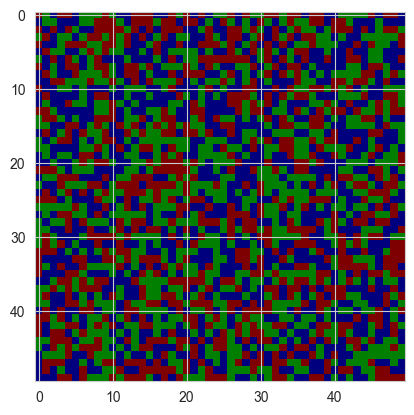

In [146]:
first_board = Board(50, 50)
first_board.show_img()

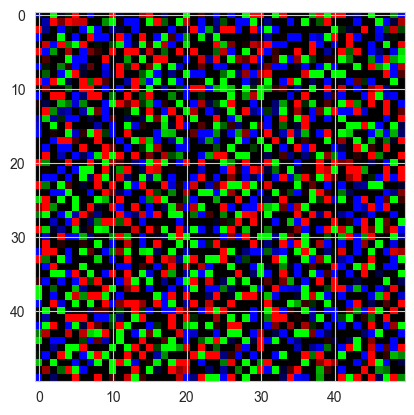

In [153]:
track_data = first_board.track(900)
first_board.show_img()

In [134]:
track_data

,turn,"accuracy (0, 0)","entropy (0, 0)"
0,2,0.000000,inf
1,7,0.500000,0.693147
2,12,0.363636,1.011601
3,17,0.375000,0.980829
4,22,0.428571,0.847298
5,27,0.384615,0.955511
6,32,0.322581,1.131402
7,37,0.416667,0.875469
8,42,0.439024,0.823200
9,47,0.391304,0.938270


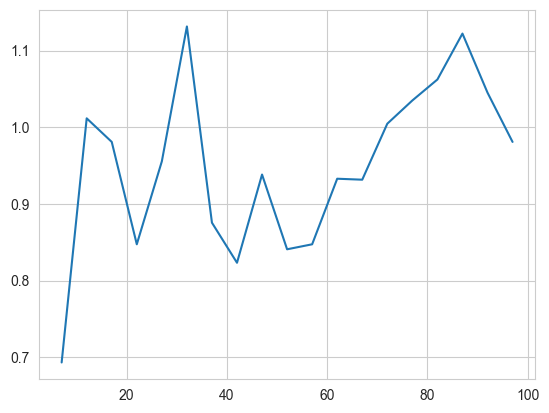

In [135]:
plt.plot(track_data['turn'], track_data['entropy (0, 0)'])
plt.show()

In [154]:
data_dict = {
    'row': [],
    'column': [],
    'hidden_layers': [],
    'hidden_size': [],
    'learning_rate': [],
    'activation': [],
    'hp': [],
    'entropy': [],
    'accuracy': [],
    'good_outcomes': [],
    'bad_outcomes': [],
}
for row in range(first_board.rows):
    for col in range(first_board.cols):
        data_dict['row'].append(row)
        data_dict['column'].append(col)
        data_dict['hidden_layers'].append(first_board.cells[row][col].hidden_layers)
        data_dict['hidden_size'].append(first_board.cells[row][col].hidden_size)
        data_dict['learning_rate'].append(first_board.cells[row][col].learn_rate)
        data_dict['activation'].append(first_board.cells[row][col].activation)
        data_dict['hp'].append(first_board.cells[row][col].hp)
        data_dict['entropy'].append(first_board.cells[row][col].entropy)
        data_dict['accuracy'].append(first_board.cells[row][col].accuracy)
        data_dict['good_outcomes'].append(first_board.cells[row][col].good_outcomes)
        data_dict['bad_outcomes'].append(first_board.cells[row][col].bad_outcomes)

result_data = pd.DataFrame(data_dict)

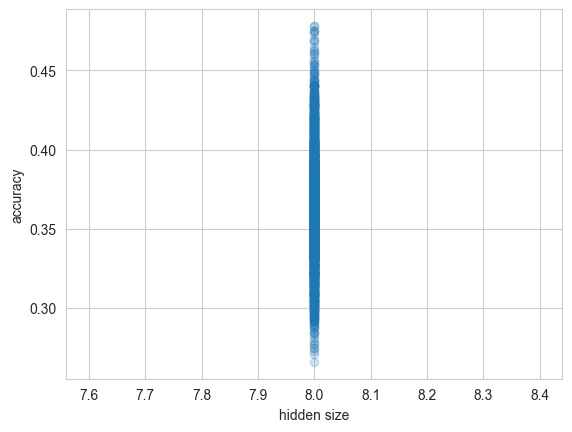

In [155]:
plt.scatter(result_data['hidden_size'], result_data['accuracy'], alpha=0.2)
plt.xlabel('hidden size')
plt.ylabel('accuracy')
plt.show()

In [156]:
first_board.num_turns

1001

In [157]:
import seaborn as sns

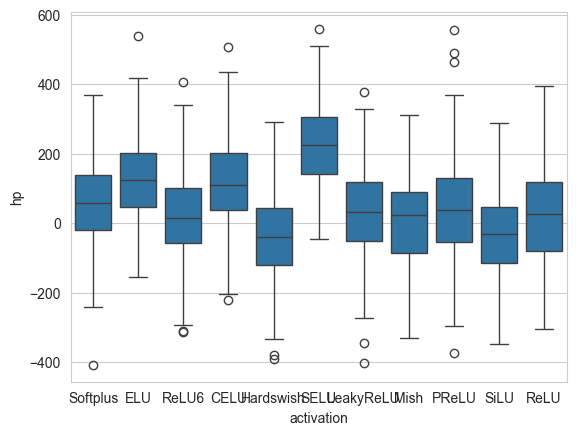

In [158]:
sns.boxplot(result_data, x='activation', y='hp')
plt.show()

In [41]:
r_stat, p_value = pearsonr(result_data['entropy'], result_data['hidden_size'])

In [42]:
print(r_stat, p_value)

-0.6349798568855973 2.5751429186683823e-282
